In [63]:
import pandas as pd
import numpy as np
import nltk
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from textblob import TextBlob
from nltk.corpus import stopwords
english_stopwords = set(stopwords.words('english'))

from nltk.tokenize import word_tokenize, TweetTokenizer
tokenizer=TweetTokenizer()

from nltk.stem import PorterStemmer, LancasterStemmer, SnowballStemmer
stemming = SnowballStemmer("english")

from nltk.stem.wordnet import WordNetLemmatizer
lemmatizing = WordNetLemmatizer()

from html.parser import HTMLParser
html_parser = HTMLParser()

from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
#loading test and train data
df_train = pd.read_csv("dataset/train.csv")
df_test = pd.read_csv("dataset/test.csv")
df_test_lables = pd.read_csv("dataset/test_labels.csv")
df_train.drop(labels=['id'], axis=1, inplace=True)
df_test.drop(labels=['id'], axis=1, inplace=True)

In [3]:
df_train.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


## Data exploration

In [4]:
print(df_train.shape)
print(df_test.shape)

(159571, 7)
(153164, 1)


In [5]:
df_train.isnull().sum()

comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [6]:
df_train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


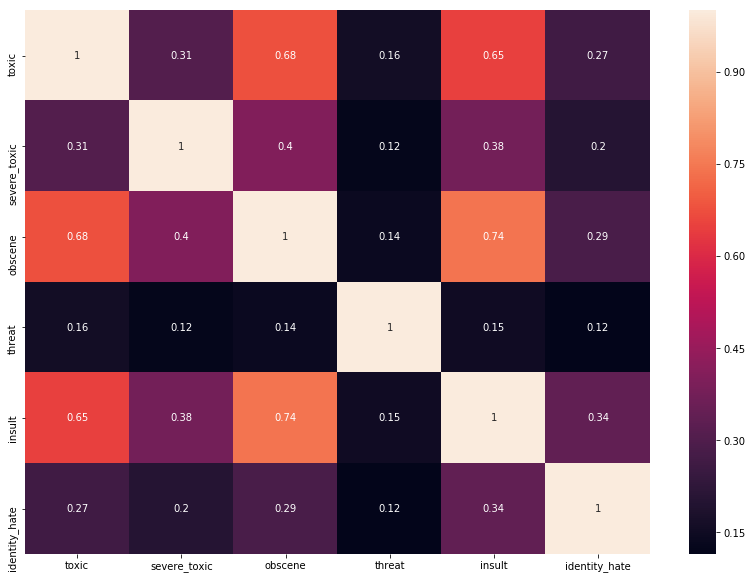

In [7]:
plt.figure(figsize=(14,10))
sns.heatmap(df_train.corr(), annot=True)

## Data preprocessing

In [8]:
#Removing HTML
df_train['comment_text'] = df_train['comment_text'].apply(lambda x: html_parser.unescape(x))
df_test["comment_text"] = df_test["comment_text"].apply(lambda x: html_parser.unescape(x))

In [9]:
#lowercase the comments
df_train['comment_text'] = df_train['comment_text'].str.lower()
df_test["comment_text"] = df_test["comment_text"].str.lower()

In [10]:
# Apostrophe Dictionary
apostrophe_dict = {
"ain't": "am not / are not",
"aren't": "are not / am not", 
"can't": "cannot", 
"can't've": "cannot have",
"'cause": "because", 
"could've": "could have", 
"couldn't": "could not", 
"couldn't've": "could not have",
"didn't": "did not", 
"doesn't": "does not",
"don't": "do not", 
"hadn't": "had not", 
"hadn't've": "had not have",
"hasn't": "has not", 
"haven't": "have not", 
"he'd": "he had / he would", 
"he'd've": "he would have",
"he'll": "he shall / he will", 
"he'll've": "he shall have / he will have", 
"he's": "he has / he is",
"how'd": "how did", 
"how'd'y": "how do you", 
"how'll": "how will", 
"how's": "how has / how is",
"i'd": "I had / I would", 
"i'd've": "I would have", 
"i'll": "I shall / I will", 
"i'll've": "I shall have / I will have",
"i'm": "I am", "I'm": "I am", 
"i've": "I have", 
"isn't": "is not", 
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}
df_train['comment_text'] = df_train['comment_text'].replace(apostrophe_dict, regex=True)

In [11]:
#Emoticon Lookup
# emoticon_dict = {
# ":\)": " happy ", ":‑\)": " happy ", ":-\]": " happy ", ":-3": " happy ", ":->": " happy ", "8-\)": " happy ",
# ":-\}": " happy ", ":o\)": " happy ", ":c\)": " happy ", ":^\)": " happy ", "=\]": " happy ", "=\)": " happy ",
# "<3": " happy ", ";\)": " happy ", "\(-:": " happy ", "\(:": " happy ", ":d": " happy ", ":p": " happy ",
# ":dd": " happy ", "8\)": " happy ", ":-\(": " sad ", ":\(": " sad ", ":c": " sad ", ":<": " sad ", ":\[": " sad ",
# ">:\[": " sad ", ":\{": " sad ", ">:\(": " sad ", ":-c": " sad ", ":-< ": " sad ", ":-\[": " sad ", ":-||": " sad ",
# ":/": " sad ", ":s": " sad ", ":-s": " sad "
# }
# df_train['comment_text'] = df_train['comment_text'].replace(emoticon_dict, regex=True)

In [12]:
short_word_dict = {
" 121 ": "one to one", " a/s/l ": "age, sex, location", " adn ": "any day now", " afaik ": "as far as I know",
" afk ": "away from keyboard", " aight ": "alright", " alol ": "actually laughing out loud", " b4 ": "before",
" b4n ": "bye for now", " bak ": "back at the keyboard", " bf ": "boyfriend", " bff ": "best friends forever", 
" bfn ": "bye for now", " bg ": "big grin", " bta ": "but then again", " btw ": "by the way", 
" cid ": "crying in disgrace", " cnp ": "continued in my next post", " cp ": "chat post", " cu ": "see you",
" cul ": "see you later", " cul8r ": "see you later", " cya ": "bye", " cyo ": "see you online",
" dbau ": "doing business as usual", " fud ": "fear, uncertainty, and doubt", " fwiw ": "for what it's worth",
" fyi ": "for your information", " g ": "grin", " g2g ": "got to go", " ga ": "go ahead", " gal ": "get a life",
" gf ": "girlfriend", " gfn ": "gone for now", " gmbo ": "giggling my butt off", " gmta ": "great minds think alike",
" h8 ": "hate", " hagn ": "have a good night", " hdop ": "help delete online predators", " hhis ": "hanging head in shame",
" iac ": "in any case", " ianal ": "I am not a lawyer", " ic ": "I see", " idk ": "I don't know",
" imao ": "in my arrogant opinion", " imnsho ": "in my not so humble opinion", " imo ": "in my opinion",
" iow ": "in other words", " ipn ": "I’m posting naked", " irl ": "in real life", " jk ": "just kidding",
" l8r ": "later", " ld ": "later, dude", " ldr ": "long distance relationship", " llta ": "lots and lots of thunderous applause",
" lmao ": "laugh my ass off", " lmirl ": "let's meet in real life", " lol ": "laugh out loud", 
" ltr ": "longterm relationship", " lulab ": "love you like a brother", " lulas ": "love you like a sister",
" luv ": "love", " m/f ": "male or female", " m8 ": "mate", " milf ": "mother I would like to fuck", 
" oll ": "online love", " omg ": "oh my god", " otoh ": "on the other hand", " pir ": "parent in room", 
" ppl ": "people", " r ": "are", " rofl ": "roll on the floor laughing", " rpg ": "role playing games",
" ru ": "are you", " shid ": "slaps head in disgust", " somy ": "sick of me yet", " sot ": "short of time",
" thanx ": "thanks", " thx ": "thanks", " ttyl ": "talk to you later", " u ": "you", " ur ": "you are",
" uw ": "you’re welcome", " wb ": "welcome back", " wfm ": "works for me", " wibni ": "wouldn't it be nice if",
" wtf ": "what the fuck", " wtg ": "way to go", " wtgp ": "want to go private", " ym ": "young man", " gr8 ": "great"
}
df_train['comment_text'] = df_train['comment_text'].replace(short_word_dict, regex=True)

In [15]:
def train_words_cleaning(text):
#     #replace paranthesis
#     text = text.str.replace(r"\(.*\)","")
#     #replace square brackets
#     text = text.str.replace(r"\[.*\]","")
    #replace newline characters
    text = text.replace('\n',' ', regex=True)
    #replace carriage return characters
    text = text.replace('\r',' ', regex=True)
    #replace tab characters
    text = text.replace('\t',' ', regex=True)
    #replace form feed characters
    text = text.replace('\f',' ', regex=True)
    #replace " " " 
    text = text.replace("\"",'', regex=True)
    #replace " ' "
    text = text.replace("\'",'', regex=True)
    #replace "anything except alphanumeric"
    text = text.replace('[^A-Za-z\s]+', '', regex=True)
    #replace "multiple whitespace with single whitespace
    text = text.replace('[ ]+', ' ', regex=True)
    #stripping the sentense from left and right
    text = text.str.strip()
    # deleting numbers
    text = text.str.replace('\d+', '', regex=True)
    return text

def test_words_cleaning():
    #replace newline characters
    df_test['comment_text'] = df_test['comment_text'].replace('\n',' ', regex=True)
    #replace carriage return characters
    df_test['comment_text'] = df_test['comment_text'].replace('\r',' ', regex=True)
    #replace tab characters
    df_test['comment_text'] = df_test['comment_text'].replace('\t',' ', regex=True)
    #replace form feed characters
    df_test['comment_text'] = df_test['comment_text'].replace('\f',' ', regex=True)
    #replace " " " 
    df_test['comment_text'] = df_test['comment_text'].replace("\"",'', regex=True)
    #replace " ' "
    df_test['comment_text'] = df_test['comment_text'].replace("\'",'', regex=True)
    #replace "anything except alphanumeric"
    df_test['comment_text'] = df_test['comment_text'].replace('[^A-Za-z\s]+', '', regex=True)
    #replace "multiple whitespace with single whitespace
    df_test['comment_text'] = df_test['comment_text'].replace('[ ]+', ' ', regex=True)
    #stripping the sentense from left and right
    df_test['comment_text'] = df_test['comment_text'].str.strip()
    # deleting numbers
    df_test['comment_text'] = df_test['comment_text'].str.replace('\d+', '', regex=True)
    return df_test['comment_text']

In [22]:
def words_engineering(text):
    text = text.apply(lambda x: word_tokenize(x))
    text = text.apply(lambda x: [w for w in x if not w in english_stopwords])
    text = text.apply(lambda x: [stemming.stem(i) for i in x])
    text = text.apply(lambda x: ' '.join([lemmatizing.lemmatize(i, "v") for i in x]))
    return text

In [23]:
def train_cleaning():
    df_train['comment_text'] = train_words_cleaning(df_train['comment_text'])
    df_train['comment_text'] = words_engineering(df_train['comment_text'])
    return df_train['comment_text']

In [28]:
def test_cleaning():
    df_test = test_words_cleaning()
    df_test = words_engineering(df_test)
    return df_test

In [25]:
df_train['comment_text'] = train_cleaning()

In [29]:
df_test = test_cleaning()

In [31]:
# creating new column named clean which does not contain any toxic comment
df_train['clean'] = np.where((df_train['toxic'] == 0) & (df_train['severe_toxic'] == 0) & 
                       (df_train['obscene'] == 0) & (df_train['threat'] == 0) &
                       (df_train['insult'] == 0) & (df_train['identity_hate'] == 0), 1, 0)
df_test_lables['clean'] = np.where((df_test_lables['toxic'] == 0) & (df_test_lables['severe_toxic'] == 0) & 
                       (df_test_lables['obscene'] == 0) & (df_test_lables['threat'] == 0) &
                       (df_test_lables['insult'] == 0) & (df_test_lables['identity_hate'] == 0), 1, 0)

In [32]:
#number of each type of toxic comments 
comment_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'clean']
comment_counts_train = []
def count_comment_val(comment_columns):
    for i in range(len(comment_columns)):
        comment_counts_train.append(df_train[comment_columns[i]].sum())
    return comment_counts_train

In [33]:
print(count_comment_val(comment_columns))

[15294, 1595, 8449, 478, 7877, 1405, 143346]


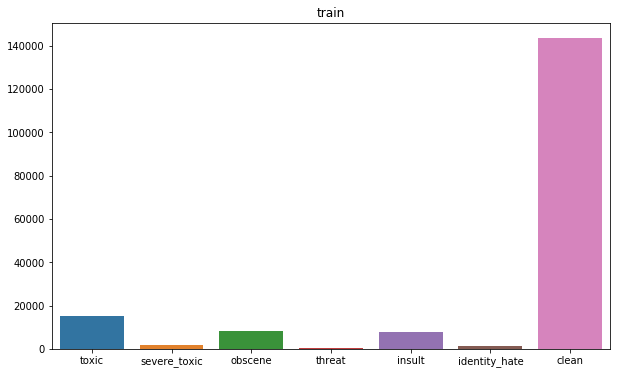

In [34]:
plt.figure(figsize=(10,6))
plt.title("train")
sns.barplot(x=comment_columns, y=comment_counts_train)

In [35]:
#replacing "" values with unknown
df_train.loc[df_train['comment_text'] == '', 'comment_text'] = 'unknown'

In [36]:
import demoji
demoji.download_codes()

... OK (Got response in 0.16 seconds)
Writing emoji data to /Users/thesarang/.demoji/codes.json ...
... OK


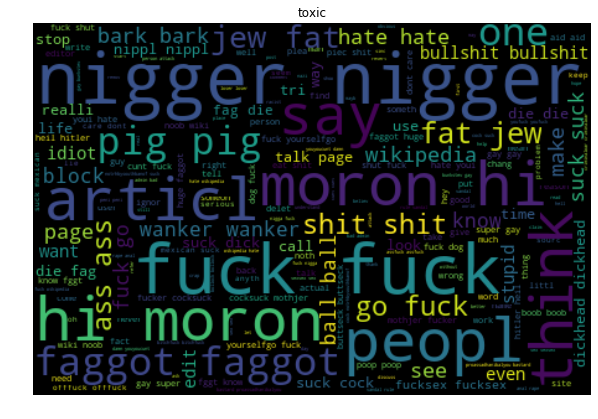

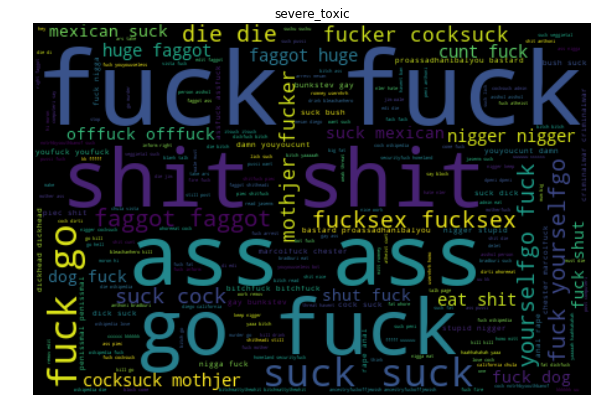

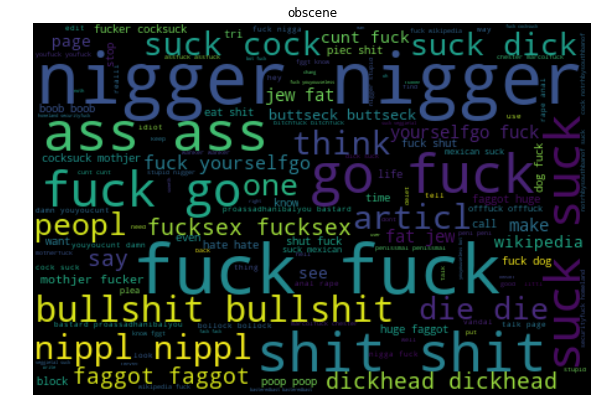

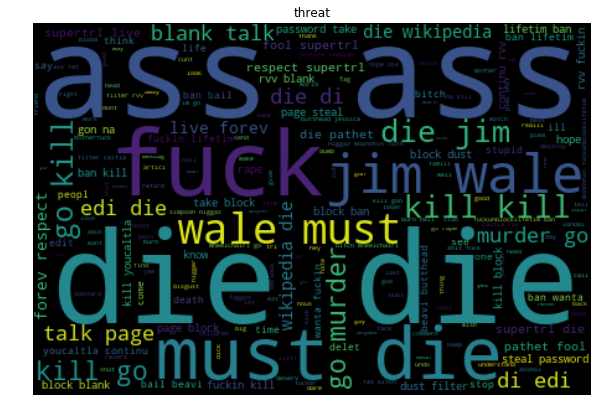

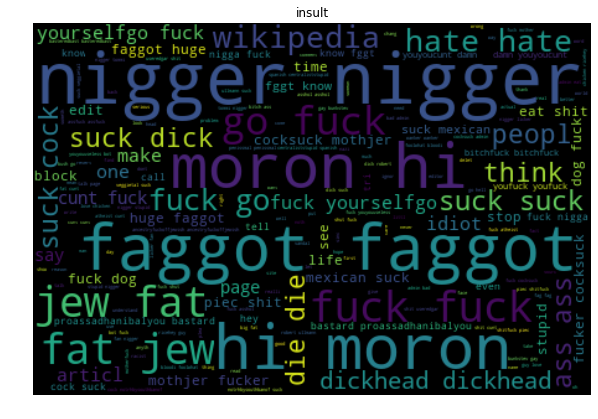

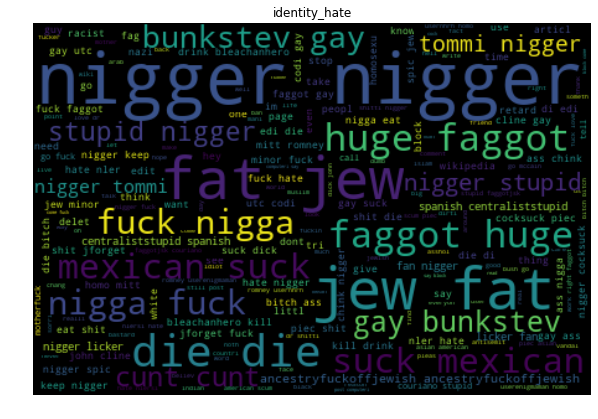

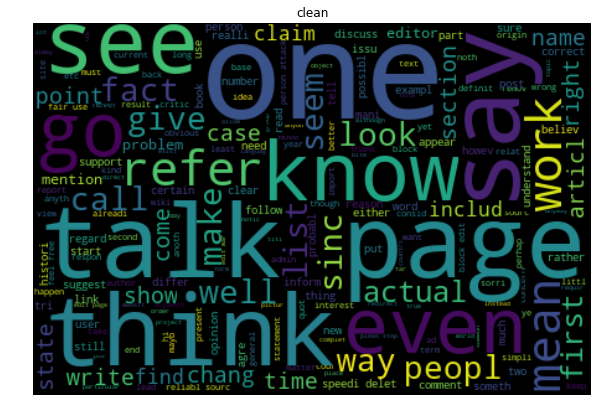

In [37]:
tags = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'clean']
def wordcloud():
    for x in tags:
        tags_sent = df_train.loc[df_train[x] == 1, 'comment_text']
        all_words = ' '.join([text for text in tags_sent])
        wordcloud = WordCloud(width=450, height=300, max_font_size=110, random_state=1).generate(all_words)
        plt.figure(figsize=(10, 7))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis('off')
        plt.title(x)
        plt.show()
wordcloud()

In [38]:
#Bag of Words

In [39]:
tokenizer = TfidfVectorizer(min_df=100,  max_features=30000, strip_accents='unicode', analyzer='char', 
                            ngram_range=(1,3), use_idf=1, smooth_idf=1,sublinear_tf=1, stop_words = 'english')
tokenizer.fit(df_train['comment_text'])
df_traintf = tokenizer.transform(df_train['comment_text'])
df_traintf = pd.DataFrame(df_traintf.toarray(), columns = tokenizer.get_feature_names())

In [41]:
df_testf = tokenizer.transform(df_test)
df_testf = pd.DataFrame(df_testf.toarray(), columns = tokenizer.get_feature_names())

In [43]:
df_test_lables.drop(labels=['id'], axis=1, inplace=True)

In [ ]:
# df_trainy = df_train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult','identity_hate', 'clean']]
# df_trainy

In [44]:
df_train.shape

(159571, 8)

In [45]:
df_traintf.shape

(159571, 6236)

In [46]:
df_final = pd.concat([df_train, df_traintf], axis=1)

In [49]:
df_final.drop(labels='comment_text', axis=1, inplace=True)

KeyError: "['comment_text'] not found in axis"

## Modeling is in process